In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import shap
from xgboost import XGBClassifier
# import random forest regressor
from sklearn.ensemble import RandomForestRegressor
#import linear regression
from sklearn.linear_model import LinearRegression
# import tqdm
from tqdm import tqdm
import tqdm
#import r2_score
from sklearn.metrics import r2_score
#import confusion matrix
from sklearn.metrics import confusion_matrix
# import roc auc score
from sklearn.metrics import roc_auc_score
from food_crisis_functions import *
import json
with open("forecasting_hyperparameters.json", "r") as file:
    best_params_xgb_regressor= json.load(file)
    
with open("forecasting_hyperparameters_p3.json", "r") as file:
    best_params_xgb_regressor_for_p3= json.load(file)
# read csv
df = pd.read_csv(r'C:\Users\swl00\IFPRI Dropbox\Weilun Shi\Google fund\Analysis\1.Source Data\forecasting_subset_IPCCH_v1210.csv')
# add dummys for area_id and month year
#df = pd.concat([df, pd.get_dummies(df['area_id'], prefix='area_id')], axis=1)
#df = pd.concat([df, pd.get_dummies(df['date'], prefix='month_year')], axis=1)
# drop lat and lon
#df = df.drop(['lat', 'lon'], axis=1)
###drop fews_ipc_ha
#df = df.drop(['fews_ipc_ha'], axis=1)
# random split train and test

# prepare date from year and month
df['date'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))
# check for inf and replace with na
df = df.replace([np.inf, -np.inf], np.nan)

# replace df['overall_phase], 0 as 1, >5 as 5
df['overall_phase'] = df['overall_phase'].apply(lambda x: 1 if x < 1 else (5 if x > 5 else x))

df_origin = df.copy()
y_pred_test = pd.DataFrame()
model_stats = pd.DataFrame()
#select phase1_percent is not na
df = df_origin[df_origin['phase1_percent'].notna()]

# Sort by region and date
df = df.sort_values(by=['area_id', 'date'])
#drop overall phase
df = df.drop(['overall_phase'], axis=1)
#for each region, set last observation to be test set
# create a series of new outcome, phase2_worse=phase2_percent+phase3_percent+phase4_percent+phase5_percent, phase3_worse=phase3_percent+phase4_percent+phase5_percent, phase4_worse=phase4_percent+phase5_percent, phase5_worse=phase5_percent
df['phase2_worse'] = df['phase2_percent'] + df['phase3_percent'] + df['phase4_percent'] + df['phase5_percent']
df['phase3_worse'] = df['phase3_percent'] + df['phase4_percent'] + df['phase5_percent']
df['phase4_worse'] = df['phase4_percent'] + df['phase5_percent']
df['phase5_worse'] = df['phase5_percent']
#drop phase2_percent, phase3_percent, phase4_percent, phase5_percent, phase1_percent
df = df.drop(['phase2_percent', 'phase3_percent', 'phase4_percent', 'phase5_percent', 'phase1_percent'], axis=1)
# Splitting the data
#test_df = df.groupby('area_id').tail(1)
#train_df = df.drop(test_df.index)
#test_df = test_df.drop(['area_id','date'], axis=1)
#train_df = train_df.drop(['area_id','date'], axis=1)


# Splitting the data
#test_df = df.groupby('area_id').tail(1)
#train_df = df.drop(test_df.index)
#test_df = test_df.drop(['area_id','date'], axis=1)
#train_df = train_df.drop(['area_id','date'], axis=1)
y_pred_test = pd.DataFrame()
# drop anything after 2022-01-01
#df = df[df['date'] < '2021-01-01']
shape_values_df_ensemble = pd.DataFrame()
df_result = pd.DataFrame()
date = "2022-01-01"  # Define the 'date' variable
cutoff_date = "2023-01-01"
#order unique_dates
y_pred_test=pd.DataFrame()

for i in range(2, 6):
    train_df = df[df['date'] < date]
    test_df = df[(df['date'] < cutoff_date) & (df['date'] >= date)]
    train_df = train_df.drop(['date','area_id'], axis=1)
    test_df = test_df.drop(['date','area_id'], axis=1)
    train_df_new = train_df.drop(['phase{}_worse'.format(j) for j in range(2, 6) if j != i], axis=1)
    test_df_new = test_df.drop(['phase{}_worse'.format(j) for j in range(2, 6) if j != i], axis=1)
# drop rows with NaN in phase{}_percent
    train_df_new = train_df_new.dropna(subset=['phase{}_worse'.format(i)])
    test_df_new = test_df_new.dropna(subset=['phase{}_worse'.format(i)])
    test_index = test_df_new.index
    # Split into features and target
    X_train = train_df_new.drop('phase{}_worse'.format(i), axis=1)
    y_train = train_df_new['phase{}_worse'.format(i)]
    X_test = test_df_new.drop('phase{}_worse'.format(i), axis=1)
    y_test = test_df_new['phase{}_worse'.format(i)]
    #fews_ipc_ha_test = X_test['fews_ipc_ha']
    #X_train = X_train.drop(['fews_ipc_ha'], axis=1)
    #X_test = X_test.drop(['fews_ipc_ha'], axis=1)
    if i == 3:
        best_params_xgb_regressor = best_params_xgb_regressor_for_p3
    model = xgb.XGBRegressor(**best_params_xgb_regressor)
    model.fit(X_train, y_train)
    # Predictions
    y_pred = model.predict(X_test)
    # for y_pred_test, add a column to indicate the phase
    #y_pred_test = pd.concat([y_pred_test, pd.DataFrame({'y_pred': y_pred, 'y_test': y_test, 'phase': [i]*len(y_pred),'fews_ipc_ha':fews_ipc_ha_test,'test_index':test_index})], ignore_index=True)
    y_pred_test = pd.concat([y_pred_test, pd.DataFrame({'y_pred': y_pred, 'y_test': y_test, 'phase': [i]*len(y_pred),'test_index':test_index})], ignore_index=True)
   
    # shap values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    
    #save shap values
    shap_values_df = pd.DataFrame(shap_values, columns=X_train.columns)
    
    # add a column to indicate the phase
    shap_values_df['phase'] = i
    
    # append to shape_values_df_ensemble
    shape_values_df_ensemble = pd.concat([shape_values_df_ensemble, shap_values_df], ignore_index=True)
y_pred_test = convert_prob_to_phase(y_pred_test)
y_test = y_pred_test['overall_phase']
y_pred = y_pred_test['overall_phase_pred']

# confusion matrix
cm = confusion_matrix(y_test, y_pred)


accuracy_score_new, sensitivity, precision, overall_r2 = all_metrics(y_test, y_pred, cm, y_pred_test)


In [2]:
# define meterological variables
geo_vars = [ 'distance_to_nearest_acled',
 'distance_to_river',
 'elevation',
 'estimated_population', 'market_access',
 'market_distance', 'popdensity', 'ruggedness',
 'sg_cec_5-15cm',
 'sg_cfvo_5-15cm',
 'sg_nitrogen_5-15cm',
 'sg_phh2o_5-15cm',
 'sg_soc_5-15cm',
 'slope']


food_prices_vars = [ 'FAO_price_l12',
 'FAO_price_v12',
 'Food_CPI',
 'Food_food_inflation', 'WFP_Price_l12',
 'WFP_Price_std_l12',
 'WFP_Price_std_v12',
 'WFP_Price_v12']
#rename WFP_Price_Change_s12_l12 to 

weather_vars = [ 'Evap_tavg_mean_l12',
 'Evap_tavg_mean_v12',
 'Evap_tavg_stdDev_l12',
 'Evap_tavg_stdDev_v12', 'LWdown_f_tavg_mean_l12',
 'LWdown_f_tavg_mean_v12',
 'LWdown_f_tavg_stdDev_l12',
 'LWdown_f_tavg_stdDev_v12',
 'Lwnet_tavg_mean_l12',
 'Lwnet_tavg_mean_v12',
 'Lwnet_tavg_stdDev_l12',
 'Lwnet_tavg_stdDev_v12',
 'Psurf_f_tavg_mean_l12',
 'Psurf_f_tavg_mean_v12',
 'Psurf_f_tavg_stdDev_l12',
 'Psurf_f_tavg_stdDev_v12',
 'Qair_f_tavg_mean_l12',
 'Qair_f_tavg_mean_v12',
 'Qair_f_tavg_stdDev_l12',
 'Qair_f_tavg_stdDev_v12',
 'Qg_tavg_mean_l12',
 'Qg_tavg_mean_v12',
 'Qg_tavg_stdDev_l12',
 'Qg_tavg_stdDev_v12',
 'Qh_tavg_mean_l12',
 'Qh_tavg_mean_v12',
 'Qh_tavg_stdDev_l12',
 'Qh_tavg_stdDev_v12',
 'Qle_tavg_mean_l12',
 'Qle_tavg_mean_v12',
 'Qle_tavg_stdDev_l12',
 'Qle_tavg_stdDev_v12',
 'Qs_tavg_mean_l12',
 'Qs_tavg_mean_v12',
 'Qs_tavg_stdDev_l12',
 'Qs_tavg_stdDev_v12',
 'Qsb_tavg_mean_l12',
 'Qsb_tavg_mean_v12',
 'Qsb_tavg_stdDev_l12',
 'Qsb_tavg_stdDev_v12',
 'RadT_tavg_mean_l12',
 'RadT_tavg_mean_v12',
 'RadT_tavg_stdDev_l12',
 'RadT_tavg_stdDev_v12',
 'Rainf_f_tavg_mean_l12',
 'Rainf_f_tavg_mean_v12',
 'Rainf_f_tavg_stdDev_l12',
 'Rainf_f_tavg_stdDev_v12',
 'Rainf_zscore',
 'SWE_inst_mean_l12',
 'SWE_inst_mean_v12',
 'SWE_inst_stdDev_l12',
 'SWE_inst_stdDev_v12',
 'SWdown_f_tavg_mean_l12',
 'SWdown_f_tavg_mean_v12',
 'SWdown_f_tavg_stdDev_l12',
 'SWdown_f_tavg_stdDev_v12',
 'SnowCover_inst_mean_l12',
 'SnowCover_inst_mean_v12',
 'SnowCover_inst_stdDev_l12',
 'SnowCover_inst_stdDev_v12',
 'SnowDepth_inst_mean_l12',
 'SnowDepth_inst_mean_v12',
 'SnowDepth_inst_stdDev_l12',
 'SnowDepth_inst_stdDev_v12',
 'Snowf_tavg_mean_l12',
 'Snowf_tavg_mean_v12',
 'Snowf_tavg_stdDev_l12',
 'Snowf_tavg_stdDev_v12', 'Swnet_tavg_mean_l12',
 'Swnet_tavg_mean_v12',
 'Swnet_tavg_stdDev_l12',
 'Swnet_tavg_stdDev_v12',
 'Tair_f_tavg_mean_l12',
 'Tair_f_tavg_mean_v12',
 'Tair_f_tavg_stdDev_l12',
 'Tair_f_tavg_stdDev_v12', 'Tair_zscore', 'Wind_f_tavg_mean_l12',
 'Wind_f_tavg_mean_v12',
 'Wind_f_tavg_stdDev_l12',
 'Wind_f_tavg_stdDev_v12']

#define economic variables
econ_vars = [ 'CC_l12',
 'CC_v12',
 'CPI_l12',
 'CPI_v12', 'GDP_l12',
 'GDP_v12',
 'GPP_mean_l12',
 'GPP_mean_v12',
 'GPP_std_l12',
 'GPP_std_v12', 'gini_l12',
 'gini_v12', 'nightlight_mean_l12',
 'nightlight_mean_v12',
 'nightlight_std_l12',
 'nightlight_std_v12']

#define conflict variables
conflict_vars = [  'event_count_battles_l12',
 'event_count_battles_v12',
 'event_count_battles_w10_l12',
 'event_count_battles_w10_v12',
 'event_count_battles_w5_l12',
 'event_count_battles_w5_v12',
 'event_count_explosions_l12',
 'event_count_explosions_v12',
 'event_count_explosions_w10_l12',
 'event_count_explosions_w10_v12',
 'event_count_explosions_w5_l12',
 'event_count_explosions_w5_v12',
 'event_count_violence_l12',
 'event_count_violence_v12',
 'event_count_violence_w10_l12',
 'event_count_violence_w10_v12',
 'event_count_violence_w5_l12',
 'event_count_violence_w5_v12', 'sum_fatalities_battles_l12',
 'sum_fatalities_battles_v12',
 'sum_fatalities_battles_w10_l12',
 'sum_fatalities_battles_w10_v12',
 'sum_fatalities_battles_w5_l12',
 'sum_fatalities_battles_w5_v12',
 'sum_fatalities_explosions_l12',
 'sum_fatalities_explosions_m12',
 'sum_fatalities_explosions_v12',
 'sum_fatalities_explosions_w10_l12',
 'sum_fatalities_explosions_w10_v12',
 'sum_fatalities_explosions_w5_l12',
 'sum_fatalities_explosions_w5_v12',
 'sum_fatalities_violence_l12',
 'sum_fatalities_violence_v12',
 'sum_fatalities_violence_w10_l12',
 'sum_fatalities_violence_w10_v12',
 'sum_fatalities_violence_w5_l12',
 'sum_fatalities_violence_w5_v12'
]

#define agricultural variables

agri_vars = ['AEZ_32000',
 'AEZ_34000',
 'AEZ_36000',
 'AEZ_38000',
 'AEZ_42000',
 'AEZ_7000',  'AEZ_10000',
 'AEZ_12000',
 'AEZ_17000',
 'AEZ_19000',
 'AEZ_20000',
 'AEZ_25000',
 'AEZ_28000',
 'AEZ_30000',
 'AEZ_31000',
 'AEZ_33000',
 'AEZ_35000',
 'AEZ_4000',
 'AEZ_40000',
 'AEZ_43000',
 'AEZ_9000','EVI_mean_l12',
 'EVI_mean_v12',
 'EVI_std_l12',
 'EVI_std_v12', 'SoilMoi00_10cm_tavg_mean_l12',
 'SoilMoi00_10cm_tavg_mean_v12',
 'SoilMoi00_10cm_tavg_stdDev_l12',
 'SoilMoi00_10cm_tavg_stdDev_v12',
 'SoilMoi100_200cm_tavg_mean_l12',
 'SoilMoi100_200cm_tavg_mean_v12',
 'SoilMoi100_200cm_tavg_stdDev_l12',
 'SoilMoi100_200cm_tavg_stdDev_v12',
 'SoilMoi10_40cm_tavg_mean_l12',
 'SoilMoi10_40cm_tavg_mean_v12',
 'SoilMoi10_40cm_tavg_stdDev_l12',
 'SoilMoi10_40cm_tavg_stdDev_v12',
 'SoilMoi40_100cm_tavg_mean_l12',
 'SoilMoi40_100cm_tavg_mean_v12',
 'SoilMoi40_100cm_tavg_stdDev_l12',
 'SoilMoi40_100cm_tavg_stdDev_v12',
 'SoilTemp00_10cm_tavg_mean_l12',
 'SoilTemp00_10cm_tavg_mean_v12',
 'SoilTemp00_10cm_tavg_stdDev_l12',
 'SoilTemp00_10cm_tavg_stdDev_v12',
 'SoilTemp100_200cm_tavg_mean_l12',
 'SoilTemp100_200cm_tavg_mean_v12',
 'SoilTemp100_200cm_tavg_stdDev_l12',
 'SoilTemp100_200cm_tavg_stdDev_v12',
 'SoilTemp10_40cm_tavg_mean_l12',
 'SoilTemp10_40cm_tavg_mean_v12',
 'SoilTemp10_40cm_tavg_stdDev_l12',
 'SoilTemp10_40cm_tavg_stdDev_v12',
 'SoilTemp40_100cm_tavg_mean_l12',
 'SoilTemp40_100cm_tavg_mean_v12',
 'SoilTemp40_100cm_tavg_stdDev_l12',
 'SoilTemp40_100cm_tavg_stdDev_v12', 'crop', 'range']

***SHAP value, grouped, normalized***

In [3]:
# for each phase, sum up the shap values
shap_values_df_ensemble_sum = shape_values_df_ensemble.groupby('phase').sum()

#select phase != 2
shap_values_df_ensemble_sum = shap_values_df_ensemble_sum.drop([2], axis=0)
# take absolute value for each column
shap_values_df_ensemble_sum_abs = shap_values_df_ensemble_sum.abs()
# plot each phase in subplots, only plot the top 10 features
def rename_shap_feature_names(shap_values_df_ensemble_sum_abs, row_index=None):
    # Define the mapping dictionary
    feature_mapping = {
        'WFP_Price_Volatility': 'WFP Price Volatility',
        'lat': 'Latitude',
        'temperature_2m_mean_z_l12': 'Long term Surface Temperature +',
        'infra_index_m12': 'infrastructure index *',
        'CPI': 'CPI',
        'GOSIF_GPP_m12': 'GOSIF-GPP * +',
        'area': 'Land Area',
        'shortwave_radiation_sum_m12': 'Shortwave Radiation * +',
        'aez_groupid_12000': 'Agricultural Ecological Zone 1',
        'GDP': 'GDP',
        'WFP_Price_Change_s12': 'WFP Price Change Percentage S.D. * +',
        'CC.PER.RNK': 'Control of Corruption',
        'temperature_2m_mean_l12': 'Surface Temperature +',
        'temperature_2m_mean_s12': 'Surface temperature S.D. * +',
        'WFP_Price_Volatility_l12': 'WFP Spatial Price Dispersion +',
        'infra_index_m12_l12': 'infrastructure index * +',
        'lon': 'Longitude',
        'WFP_Price_Change_l12': 'WFP Price change Percentage +',
        'estimated_population': 'Estimated Population',
        'EVI_l12': 'Enhanced Vegetation Index * +',
        'soil_moisture_mean_l12': 'Soil Moisture +',
        'infra_index_s12_l12': 'Infrastructure Index S.D. * +',
        'nightlight_mean_l12': 'VIIRS nightlight +',
        'shortwave_radiation_sum_l12': 'Shortwave Radiation +',
        'aez_groupid_32000': 'Agricultural Ecological Zone 2',
        'phh2o_5-15cm_mean': 'Soil P.H.',
        'rainfall_chirps_z_l12': 'Long term Ground Gauge rainfall +'
    }
    
    # If a specific row index is provided, rename only for that row
    if row_index is not None:
        # Get the top 10 features for the specified row
        top_features = shap_values_df_ensemble_sum_abs.iloc[row_index].sort_values(ascending=False)[:10]
        
        # Create a renamed Series with the mapped names
        renamed_features = top_features.copy()
        renamed_features.index = [feature_mapping.get(feature, feature) for feature in top_features.index]
        
        return renamed_features
    
    # Otherwise, apply to all rows (this would be more complex as it needs to handle the DataFrame structure)
    else:
        # Create a function to rename a single row's index
        def rename_row(row):
            sorted_row = row.sort_values(ascending=False)[:10]
            sorted_row.index = [feature_mapping.get(feature, feature) for feature in sorted_row.index]
            return sorted_row
        
        # Apply the function to each row
        renamed_df = shap_values_df_ensemble_sum_abs.apply(rename_row, axis=1)
        
        return renamed_df

# rename shap feature names for all rows



# group shap values by variable type, then plot four group of variables
shap_values_df_ensemble_sum_weather = shap_values_df_ensemble_sum[weather_vars]
shap_values_df_ensemble_sum_econ = shap_values_df_ensemble_sum[econ_vars]
shap_values_df_ensemble_sum_conflict = shap_values_df_ensemble_sum[conflict_vars]
shap_values_df_ensemble_sum_agri = shap_values_df_ensemble_sum[agri_vars]
shap_value_of_ensemble_sum_geo = shap_values_df_ensemble_sum[geo_vars]
shap_value_of_ensemble_sum_food_prices = shap_values_df_ensemble_sum[food_prices_vars]


# sum the same group of variables
shap_values_df_ensemble_sum_weather = shap_values_df_ensemble_sum_weather.sum(axis=1)
shap_values_df_ensemble_sum_econ = shap_values_df_ensemble_sum_econ.sum(axis=1)
shap_values_df_ensemble_sum_conflict = shap_values_df_ensemble_sum_conflict.sum(axis=1)
shap_values_df_ensemble_sum_agri = shap_values_df_ensemble_sum_agri.sum(axis=1)
shap_value_of_ensemble_sum_geo = shap_value_of_ensemble_sum_geo.sum(axis=1)
shap_value_of_ensemble_sum_food_prices = shap_value_of_ensemble_sum_food_prices.sum(axis=1)




# combine into a dataframe
shap_values_df_ensemble_sum_grouped = pd.concat([shap_values_df_ensemble_sum_weather, 
                                                 shap_values_df_ensemble_sum_econ, shap_values_df_ensemble_sum_conflict, 
                                                 shap_values_df_ensemble_sum_agri, shap_value_of_ensemble_sum_geo, shap_value_of_ensemble_sum_food_prices], axis=1)
# phase
#shap_values_df_ensemble_sum_grouped['phase'] = [2,3,4,5]
shap_values_df_ensemble_sum_grouped['phase'] = [3,4,5]
#shap_values_df_ensemble_sum_grouped['phase'] = [2,3,4]
# rename columns
shap_values_df_ensemble_sum_grouped.columns = ['Weather', 'Econ', 'Conflict', 'Agri', 'Geo', 'Food Prices','Phase']
# drop phase column
shap_values_df_ensemble_sum_grouped = shap_values_df_ensemble_sum_grouped.drop('Phase', axis=1)
# take absolute value, stacked bar chart, each bar is a phase
shap_values_df_ensemble_sum_grouped = shap_values_df_ensemble_sum_grouped.abs()

# normalize
shap_values_df_ensemble_sum_grouped = shap_values_df_ensemble_sum_grouped.div(shap_values_df_ensemble_sum_grouped.sum(axis=1), axis=0)

# rename phases, 3 to "phase 3 or higher", 4 to "phase 4 or higher"
shap_values_df_ensemble_sum_grouped.index = ['phase 3 or higher', 'phase 4 or higher', 'phase 5']


#remove phase 5
shap_values_df_ensemble_sum_grouped = shap_values_df_ensemble_sum_grouped.drop(["phase 5"], axis=0)

C:\Users\swl00\AppData\Local\Temp\ipykernel_22592\1421671465.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(top_features.index,fontsize=15)
C:\Users\swl00\AppData\Local\Temp\ipykernel_22592\1421671465.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(top_features.index,fontsize=15)


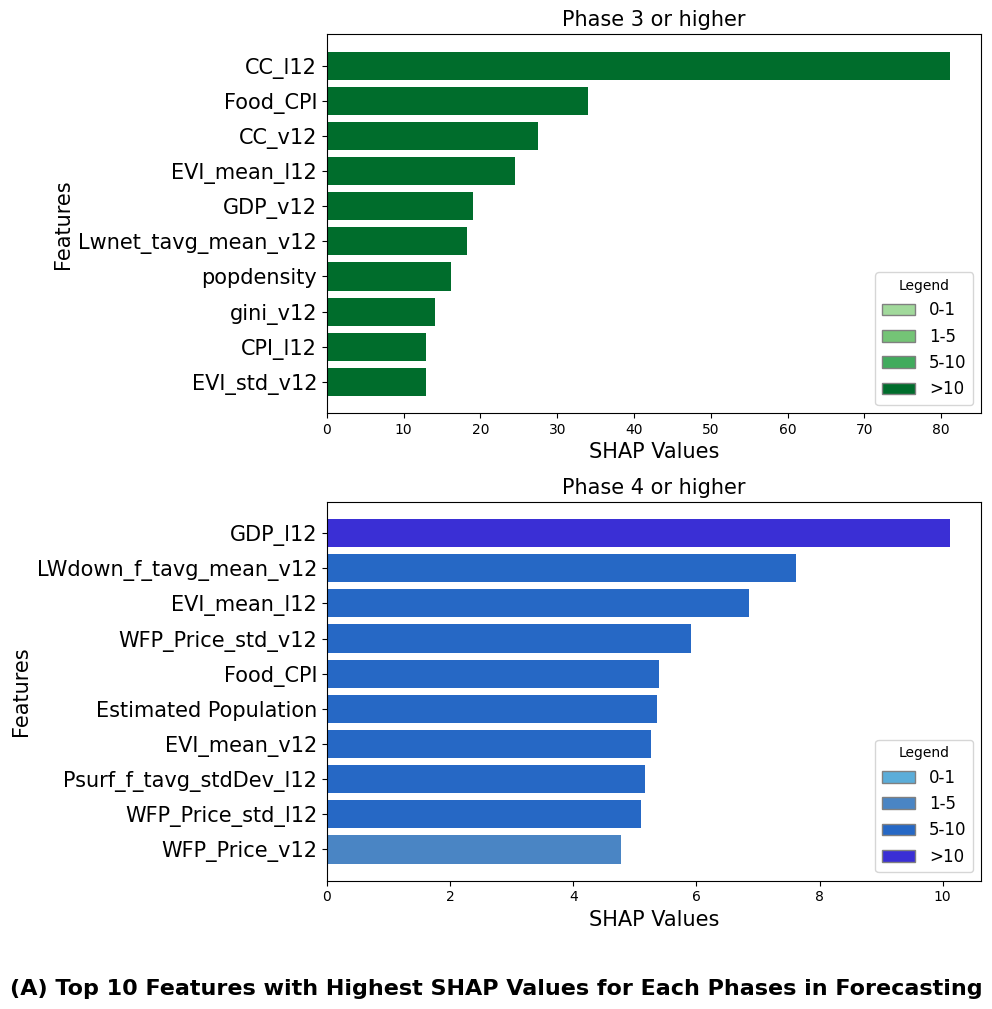

In [4]:
# For the first graph - Adding color based on SHAP value magnitude
# Define a function to assign colors based on SHAP value magnitude
def get_color_for_value(value):
    if value <= 1:
        return '#A1D99B'
    elif value <= 5:
        return '#74C476'
    elif value <= 10:
        return '#41AB5D'
    else:
        return '#006D2C'
    
def get_color_for_value_1(value):
    if value <= 1:
        return "#5BADD9"
    elif value <= 5:
        return "#4A85C4"
    elif value <= 10:
        return "#2668C5"
    else:
        return "#3A2FD5"

# Plotting the first graph with color coding
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
axes = axes.flatten()

# rename shap feature names for all rows
shap_values_df_ensemble_sum_abs = rename_shap_feature_names(shap_values_df_ensemble_sum_abs)

for i, ax in enumerate(axes):
    # Get the top 10 features
    top_features = shap_values_df_ensemble_sum_abs.iloc[i].sort_values(ascending=False)[:10]

    #reverse order of top_features
    top_features = top_features[::-1]
    
    # Create a list of colors based on SHAP values
    if i == 0:
        colors = [get_color_for_value(value) for value in top_features]
    else:
        colors = [get_color_for_value_1(value) for value in top_features]
    # Create the bar plot with custom colors
    bars = ax.barh(y=top_features.index, width=top_features, color=colors)
    ax.set_yticklabels(top_features.index,fontsize=15)
    ax.set_title('Phase {} or higher'.format(i+3),fontsize=15)
    ax.set_xlabel('SHAP Values',fontsize=15)
    ax.set_ylabel('Features',fontsize=15)  # The y-axis labels (features) might contain '+' or '*'

    # ================== START MINIMAL EDIT ==================
    # Add a legend for color meaning AND symbol meaning
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D # Import Line2D for dummy handles

    # Original legend elements for SHAP value colors
    shap_legend_elements_1 = [
        Patch(facecolor='#A1D99B', edgecolor='grey', label='0-1'),  # More Prominent Light Green
        Patch(facecolor='#74C476', edgecolor='grey', label='1-5'),  # Medium Green
        Patch(facecolor='#41AB5D', edgecolor='grey', label='5-10'), # Dark Green
        Patch(facecolor='#006D2C', edgecolor='grey', label='>10')   # Darkest Green
    ]
    shap_legend_elements_2 = [
        Patch(facecolor="#5BADD9", edgecolor='grey', label='0-1'),  # More Prominent Light Blue
        Patch(facecolor="#4A85C4", edgecolor='grey', label='1-5'),  # Medium Blue
        Patch(facecolor="#2668C5", edgecolor='grey', label='5-10'), # Dark Blue
        Patch(facecolor="#3A2FD5", edgecolor='grey', label='>10')   # Darkest Blue
    ]
    shap_legend_elements = shap_legend_elements_1 if i == 0 else shap_legend_elements_2
    shap_labels = [h.get_label() for h in shap_legend_elements]

    # Dummy handles and labels for the variable type indicators
    symbol_handles = [
        Line2D([0], [0], marker=None, color='None', linestyle='None'), # Invisible handle
        Line2D([0], [0], marker=None, color='None', linestyle='None')  # Invisible handle
    ]
    symbol_labels = ["'+': lagged 12 months", "'*': 12-month moving average"]

    # Combine all handles and labels
    all_handles = shap_legend_elements
    all_labels = shap_labels

    # Add the combined legend
    ax.legend(handles=all_handles, labels=all_labels, title="Legend", loc="lower right", fontsize=12)
    # Grouped titles can be complex; let's use one main title. Adjust loc if needed.
    
# add title under the figure, use bold font
fig.text(0.5, -0.05, '(A) Top 10 Features with Highest SHAP Values for Each Phases in Forecasting',ha='center', fontsize=16, fontweight='bold')

# apply tight layout with adjusted parameters
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave room for the suptitle

# export to jpg with 300 dpi
plt.savefig('shap_values_forecasting_phase3_phase4_colored.jpg', 
            dpi=100,
            format='jpeg',
            bbox_inches='tight',  # removes extra whitespace
            pil_kwargs={'compression': 'lzw'})  # adds LZW compression to reduce file size


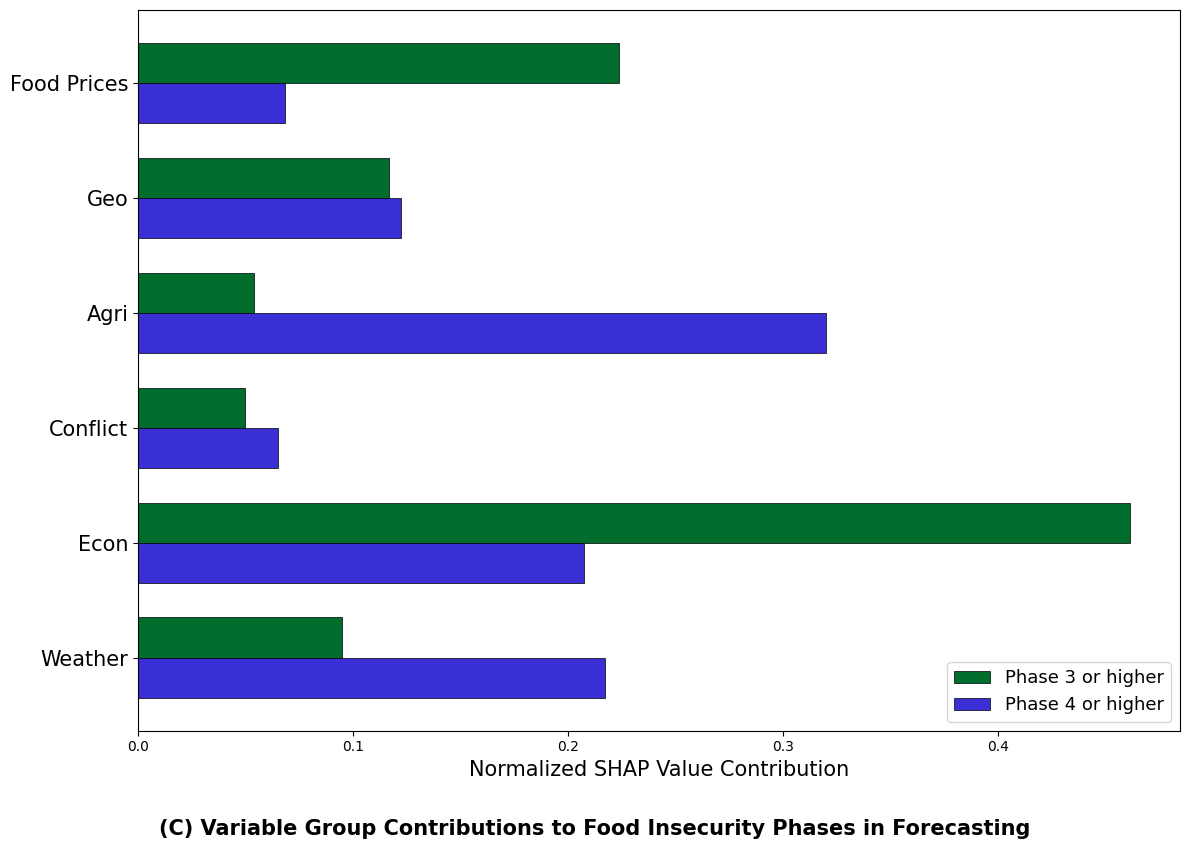

In [5]:

# For the second graph - Creating horizontal bar chart grouped by variable type
# First, let's transpose the data to get the format we need
shap_grouped_transposed = shap_values_df_ensemble_sum_grouped.T

# Create a figure with appropriate size
fig, ax = plt.subplots(figsize=(12, 8))

# Set width of bars
bar_width = 0.35
index = np.arange(len(shap_grouped_transposed))

# Get the values for each phase
phase3_values = shap_grouped_transposed['phase 3 or higher']
phase4_values = shap_grouped_transposed['phase 4 or higher']

# Use distinctive colors for each phase
phase3_color = '#006D2C'  # green
phase4_color = '#3A2FD5'  # blue

# Creating the grouped horizontal bar chart
bars1 = ax.barh(index + bar_width/2, phase3_values, bar_width, color=phase3_color, label='Phase 3 or higher', edgecolor='black', linewidth=0.5)
bars2 = ax.barh(index - bar_width/2, phase4_values, bar_width, color=phase4_color, label='Phase 4 or higher', edgecolor='black', linewidth=0.5)

# Add labels, title, and legend
ax.set_xlabel('Normalized SHAP Value Contribution',fontsize=15)
ax.set_yticks(index)
ax.set_yticklabels(shap_grouped_transposed.index,fontsize=15)
fig.text(0.5, -0.05, '(C) Variable Group Contributions to Food Insecurity Phases in Forecasting', 
         ha='center', fontsize=15,fontweight='bold')
ax.legend(loc='lower right',fontsize=13)

# Apply tight layout
plt.tight_layout()

# Export to jpg with 300 dpi
plt.savefig('shap_values_grouped_horizontal_bars.jpg', 
            dpi=300,
            format='jpeg',
            bbox_inches='tight',
            pil_kwargs={'compression': 'lzw'})

plt.show()